# Bayesian variable selection

The data for the variable selection in major depressive disorder was obtained from the Nathan Kline Institute - Rockland Sample. As we cannot share these data here, we use instead a simulated example.

In [1]:
%load_ext autoreload
%autoreload 2

import os

# For JAX, we can use CPU (set SELECTED_DEVICE to empty (''), or one of the available GPUs)
SELECTED_DEVICE = '0'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [0]


In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import jax
jax.config.update("jax_enable_x64", True)  # Do we need this here? -> it seems we do for the LML computations (otherwise NaNs get introduced), but not for performance

import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import blackjax
import pandas as pd
import jax.scipy.special as jsp

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from distrax._src.distributions.distribution import Distribution

import os
import sys

import flax
from flax import linen as nn

from blackjax import normal_random_walk

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../../')))

import bamojax
from bamojax.base import Node, Model
from bamojax.sampling import gibbs_sampler, inference_loop, run_chain, smc_inference_loop

print('Python version:       ', sys.version)
print('Jax version:          ', jax.__version__)
print('BlackJax version:     ', blackjax.__version__)
print('Flax version:         ', flax.__version__)
print('Distrax version:      ', dx.__version__)
print('BaMoJax version:      ', bamojax.__version__)
print('Jax default backend:  ', jax.default_backend())
print('Jax devices:          ', jax.devices())

SMALL_SIZE = 14
MEDIUM_SIZE = 16
LARGE_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title

Python version:        3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]
Jax version:           0.4.35
BlackJax version:      1.2.4
Flax version:          0.10.0
Distrax version:       0.1.5
BaMoJax version:       0.0.1
Jax default backend:   gpu
Jax devices:           [CudaDevice(id=0)]


In [3]:
DATA_DIR = '/home/maxhin/Documents/Code/SMC tutorial/BLR/data/Request all'
RESULTS_DIR = '/home/maxhin/Documents/Code/SMC tutorial/BLR'
FIGURES_DIR = 'figures'


def read_data(key, N=100, add_intercept=False, mode=None):
    if mode == 'bainter':
        filename = f'{DATA_DIR}/selected_variables_scaled.csv'
        df = pd.read_csv(filename, sep=',', header=[0]).drop(labels='ID', axis=1)
        data = jnp.asarray(df)
        X = data[:, 1:]        
        y = data[:, 0]
        labels = list(df.columns)
        labels.remove('DBDI_22')
        ix_age = labels.index('DEM_001')
        labels[ix_age] = 'Age'
        ix_gender = labels.index('DEM_002')
        labels[ix_gender] = 'Gender'   
        ix_nicotine = labels.index('FAGERADULT_9')
        labels[ix_nicotine] = 'Nicotine'   

        filename = f'{DATA_DIR}/DS_CODEBOOK.csv'
        df = pd.read_csv(filename, sep=',', header=[0])

        # for label in labels:
        #     full_label = df.loc[df['Question ID'] == label]['Question Label'].item()
        #     if len(full_label):
        #         print(f'{label} is short for {full_label}')        
    else:
        key, key_X, key_y = jrnd.split(key, 3)
        beta_true = jnp.array([1.0, 0.0, 0.0, 4.3, -2.8])
        p = len(beta_true)    
        X = jrnd.normal(key_X, shape=(N, p))
        sigma_true = 0.7
        y = jnp.dot(X, beta_true) + sigma_true*jrnd.normal(key_y, shape=(N, ))
        labels = None
    if add_intercept:
        X = jnp.column_stack((jnp.ones((X.shape[0], )), X))  # add intercept!
        if labels != None:
            labels.insert(0, 'Intercept')
    return X, y, labels

#

In [4]:
def boxplot_coefficients(ax, samples, ylabel, labels=None, sortbysize=True):
    
    mean = jnp.mean(samples, axis=0)
    p = len(mean)
    if sortbysize:
        ix = jnp.argsort(jnp.abs(mean))[::-1]
    else:
        ix = jnp.arange(p)
    samples = samples[:, ix]

    if labels == None:
        labels = [r'$x_{{{:d}}}$'.format(i) for i in jnp.arange(p)[ix]]
    else:
        labels = [labels[i] for i in ix]

    ax.axhline(y=0.0, lw=0.5, color='k', ls='--')
    bp = ax.boxplot(samples,
                    patch_artist=True, 
                    tick_labels=labels,
                    boxprops=dict(facecolor='#FDB97D',
                                linewidth=0.5),
                    capprops=dict(linewidth=0.5),
                    medianprops=dict(color='k',
                                    linestyle='-',
                                    linewidth=0.5),
                    flierprops=dict(markeredgewidth=0.5))

    ax.tick_params(labelrotation=90)
    ax.set_xlabel('Predictors')
    ax.set_ylabel(ylabel)
    return bp

#
def boxplots_grouped(filename, data, ylabel, labels=None, insert_pychart=None):   

    # sort coefficients by magnitude
    ix = jnp.argsort(jnp.abs(jnp.mean(data[2, :, :], axis=0)))[::-1]
    data = data[:, :, ix]

    if labels == None:
        [r'$x_{{{:d}}}$'.format(i+1) for i in ix]
    else:
        labels = [labels[i] for i in ix]

    M = data.shape[0]
    group_width = M + 1  
    positions = []
    for group in range(p):
        start_pos = group * group_width
        positions.extend([start_pos + m for m in range(M)])

    colors = plt.colormaps.get_cmap('Oranges')(jnp.linspace(0.3, 0.8, M+1))

    _, ax = plt.subplots(figsize=(12, 6))
    # ax.axhline(y=0, ls='--', c='k', lw=0.5)
    ax.grid(which='both', axis='y', color='0.95')

    for i in range(p):
        for m in range(M):
            pos = i * M + m
            ax.boxplot(data[m, :, i], 
                       positions=[positions[pos]], 
                       widths=0.6, 
                       patch_artist=True,
                       boxprops=dict(facecolor=colors[m],
                                     linewidth=0.5),
                       showcaps=False,
                       medianprops=dict(color='k',
                                        linestyle='-',
                                        linewidth=0.5),
                       whiskerprops=dict(solid_capstyle='butt', 
                                         linewidth=0.5),
                       showfliers=False)

    legend_handles = [mpatches.Patch(facecolor=colors[m], edgecolor='k', label=methods[m]) for m in range(M)]
    ax.legend(handles=legend_handles, fontsize=SMALL_SIZE, edgecolor='w', facecolor='w', framealpha=1.0, title='Method')

    ax.set_xticks(jnp.arange(p) * group_width + M/2)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('Predictor', fontsize=MEDIUM_SIZE)
    ax.set_ylabel(ylabel, fontsize=MEDIUM_SIZE)

    if insert_pychart is not None:
        ax_in = ax.inset_axes([0.5, 0.5, 0.35, 0.3])
        ax_in.bar([0, 1, 2, 3], insert_pychart, color=colors, edgecolor='k')
        methods.append('SMC (cumul.)')
        ax_in.set_xticks([0, 1, 2, 3], methods)
        ax_in.set_ylabel('Runtime (s)')

    plt.savefig(filename, bbox_inches='tight', pad_inches=0.0)
    plt.close()

#


Regular linear regression with Gaussian priors (ridge regression):

In [5]:
key = jrnd.PRNGKey(42)
key, subkey = jrnd.split(key)

print('Loading data')
X, y, labels = read_data(subkey, N=100, add_intercept=True)
p = X.shape[1]

def lin_reg_link_fn(beta, sigma, x):
    mu = jnp.dot(x, beta)
    return dict(loc=mu, scale=sigma)

#


LinearRegression = Model('BLR')
sigma = LinearRegression.add_node('sigma', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
beta = LinearRegression.add_node('beta', distribution=dx.Normal(loc=0., scale=1.), shape=(p, ))
x_node = LinearRegression.add_node('x', observations=X)
y_node = LinearRegression.add_node('y', observations=y, distribution=dx.Normal, parents=dict(beta=beta, sigma=sigma, x=x_node), link_fn=lin_reg_link_fn)

print('Gibbs conditionals: ')
LinearRegression.print_gibbs()

Loading data
Gibbs conditionals: 
Gibbs structure:
beta                : p(y | beta, sigma, x) p(beta)
sigma               : p(y | beta, x, sigma) p(sigma)


In [6]:
%%time

num_mcmc_steps = 100
num_particles = 1_000

step_fns = dict(beta=normal_random_walk, sigma=normal_random_walk)
step_fn_params = dict(beta=dict(sigma=0.05*jnp.eye(p)), sigma=dict(sigma=0.3))

gibbs = gibbs_sampler(LinearRegression, step_fns=step_fns, step_fn_params=step_fn_params)

key, subkey = jrnd.split(key)
final_state, lml, n_iter, final_info = smc_inference_loop(subkey, model=LinearRegression, kernel=gibbs, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)

for theta in ['beta', 'sigma']:
    print(f'Acceptance rate for {theta}: {jnp.mean(final_info.update_info[theta].is_accepted):0.3f}')

Acceptance rate for beta: 0.435
Acceptance rate for sigma: 0.217
CPU times: user 19.9 s, sys: 910 ms, total: 20.8 s
Wall time: 22.1 s


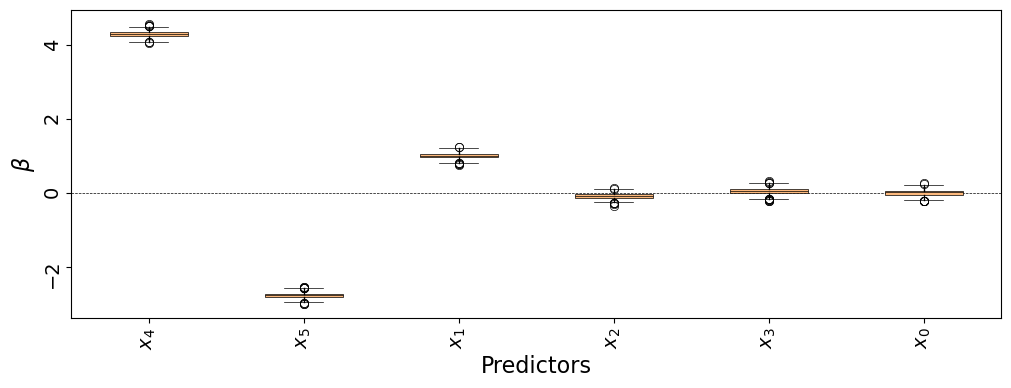

In [7]:
plt.figure(figsize=(12, 4))
_ = boxplot_coefficients(plt.gca(), final_state.particles['beta'], r'$\beta$', sortbysize=True)

Variable selection with the LN-CASS prior (regularizing coefficients towards zero; see Thomson et al., 2019):

In [8]:
mu_v = jsp.logit(0.2)
sigma_v = 1.0 

def lin_reg_link_fn(beta, sigma, x):
    mu = jnp.dot(x, beta)
    return dict(loc=mu, scale=sigma)

#

LNCASS = Model('SBLR')
sigma = LNCASS.add_node('sigma', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
tau = LNCASS.add_node('tau', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
lam = LNCASS.add_node('lam', dx.Transformed(dx.Normal(loc=mu_v*jnp.ones((p, )), scale=sigma_v*jnp.ones((p, ))), tfb.Sigmoid()))
beta = LNCASS.add_node('beta', distribution=dx.Normal, parents=dict(tau=tau, lam=lam), link_fn=lambda tau, lam: dict(loc=0.0, scale=(tau*lam)**2))
x_node = LNCASS.add_node('x', observations=X)
y_node = LNCASS.add_node('y', observations=y, distribution=dx.Normal, parents=dict(beta=beta, sigma=sigma, x=x_node), link_fn=lin_reg_link_fn)

LNCASS.print_gibbs()

Gibbs structure:
tau                 : p(beta | lam, tau) p(tau)
lam                 : p(beta | lam, tau) p(lam)
beta                : p(y | beta, sigma, x) p(beta | lam, tau)
sigma               : p(y | beta, x, sigma) p(sigma)


In [9]:
%%time

num_mcmc_steps = 100
num_particles = 1_000

step_fns = dict(beta=normal_random_walk, 
                sigma=normal_random_walk, 
                lam=normal_random_walk, 
                tau=normal_random_walk)
step_fn_params = dict(beta=dict(sigma=0.05*jnp.eye(p)), 
                      lam=dict(sigma=0.01*jnp.eye(p)), 
                      sigma=dict(sigma=0.5), 
                      tau=dict(sigma=0.5))

gibbs = gibbs_sampler(LNCASS, step_fns=step_fns, step_fn_params=step_fn_params)

key, subkey = jrnd.split(key)
final_state, lml, n_iter, final_info = smc_inference_loop(subkey, model=LNCASS, kernel=gibbs, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)

for theta in ['beta', 'sigma', 'lam', 'tau']:
    print(f'Acceptance rate for {theta}: {jnp.mean(final_info.update_info[theta].is_accepted):0.3f}')

Acceptance rate for beta: 0.313
Acceptance rate for sigma: 0.131
Acceptance rate for lam: 0.779
Acceptance rate for tau: 0.724
CPU times: user 19.2 s, sys: 801 ms, total: 20 s
Wall time: 16 s


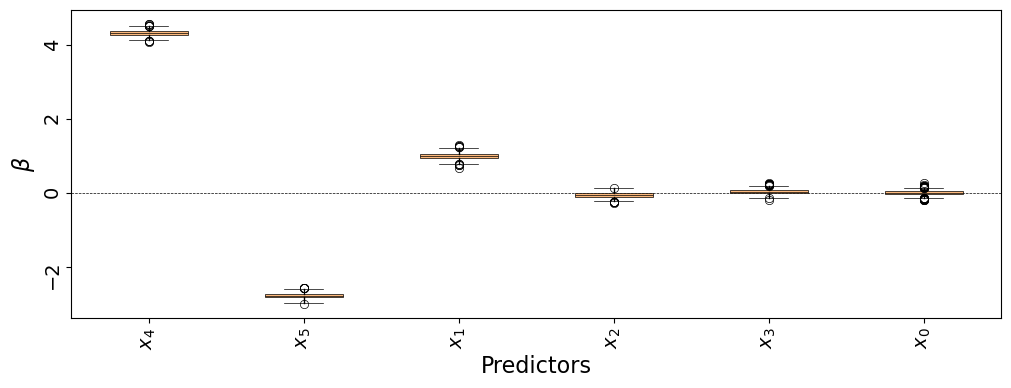

In [10]:
plt.figure(figsize=(12, 4))
_ = boxplot_coefficients(plt.gca(), final_state.particles['beta'], r'$\beta$', sortbysize=True)

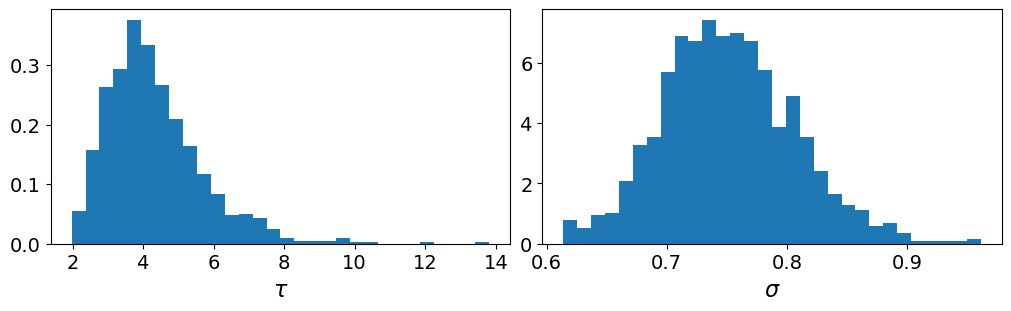

In [11]:
_, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10, 3))
for ax, theta in zip(axes, ['tau', 'sigma']):
    ax.hist(final_state.particles[theta], density=True, bins=30)
    ax.set_xlabel(fr'$\{theta}$')

Recall that true $\sigma=0.7$.

**IMPORTANT**: The number of SMC iterations depends on step sizes, and poor choices can result in memory trouble. 

With the correct settings, the model converges quickly (~50s for 200 mutations, 1000 particles) on the full dataset. The number of effective samples can be increased by adding more mutation steps, while remaining quite fast in general. With 1000 mutations and 1000 particles, the ESS is near perfect (around 4K for 4 chains, so basically all samples are independent).

In [12]:
%%time

key = jrnd.PRNGKey(42)
key, subkey = jrnd.split(key)

print('Loading data')
X, y, labels = read_data(subkey, mode='bainter', add_intercept=True)
p = X.shape[1]
print('X.shape:', X.shape)

mu_v = jsp.logit(0.2)
sigma_v = 1.0 

def lin_reg_link_fn(beta, sigma, x):
    mu = jnp.dot(x, beta)
    return dict(loc=mu, scale=sigma)

#

LNCASS = Model('SBLR')
sigma = LNCASS.add_node('sigma', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
tau = LNCASS.add_node('tau', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
lam = LNCASS.add_node('lam', dx.Transformed(dx.Normal(loc=mu_v*jnp.ones((p, )), scale=sigma_v*jnp.ones((p, ))), tfb.Sigmoid()))
beta = LNCASS.add_node('beta', distribution=dx.Normal, parents=dict(tau=tau, lam=lam), link_fn=lambda tau, lam: dict(loc=0.0, scale=(tau*lam)**2))
x_node = LNCASS.add_node('x', observations=X)
y_node = LNCASS.add_node('y', observations=y, distribution=dx.Normal, parents=dict(beta=beta, sigma=sigma, x=x_node), link_fn=lin_reg_link_fn)

num_mcmc_steps = 200
num_particles = 1_000
num_chains = 4

step_fns = dict(beta=normal_random_walk, 
                sigma=normal_random_walk, 
                lam=normal_random_walk, 
                tau=normal_random_walk)
step_fn_params = dict(beta=dict(sigma=0.001*jnp.eye(p)), 
                      lam=dict(sigma=0.01*jnp.eye(p)), 
                      sigma=dict(sigma=0.01), 
                      tau=dict(sigma=0.2))

gibbs = gibbs_sampler(LNCASS, step_fns=step_fns, step_fn_params=step_fn_params)

print('Starting inference')

final_state, lml, n_iter, final_info = smc_inference_loop(key=subkey, 
                                                          model=LNCASS, 
                                                          kernel=gibbs, 
                                                          num_particles=num_particles, 
                                                          num_mcmc_steps=num_mcmc_steps, 
                                                          num_chains=num_chains)


Loading data
X.shape: (715, 24)
Starting inference
CPU times: user 1min 9s, sys: 17.5 s, total: 1min 26s
Wall time: 1min 27s


In [13]:
from blackjax.diagnostics import potential_scale_reduction, effective_sample_size

print('Convergence assessment')
for node in ['beta', 'lam', 'sigma', 'tau']:
    psrf = potential_scale_reduction(final_state.particles[node])
    print(f'max(R({node})): {jnp.max(psrf):0.3f}')

for node in ['beta', 'lam', 'sigma', 'tau']:
    psrf = effective_sample_size(final_state.particles[node])
    print(f'ESS({node}): {jnp.max(psrf):0.3f}')

Convergence assessment
max(R(beta)): 1.025
max(R(lam)): 1.008
max(R(sigma)): 1.000
max(R(tau)): 1.000
ESS(beta): 3701.664
ESS(lam): 2135.242
ESS(sigma): 3857.639
ESS(tau): 1318.092


In [14]:
for theta in ['beta', 'sigma', 'lam', 'tau']:
    print(f'Acceptance rate for {theta}: {jnp.mean(final_info.update_info[theta].is_accepted):0.3f}')

Acceptance rate for beta: 0.175
Acceptance rate for sigma: 0.282
Acceptance rate for lam: 0.535
Acceptance rate for tau: 0.236


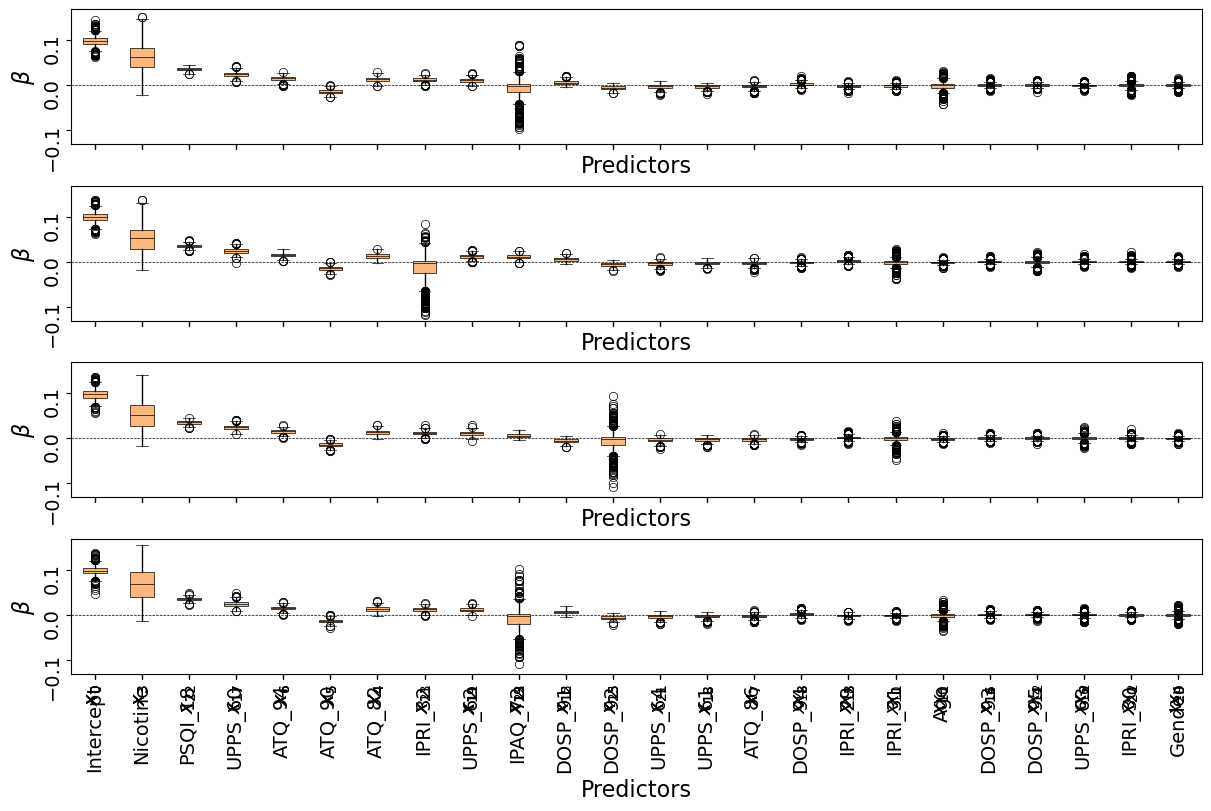

In [15]:
_, axes = plt.subplots(nrows=num_chains, ncols=1, sharex=True, sharey=True, constrained_layout=True, figsize=(12, 8))

for c, ax in enumerate(axes):
    if c == num_chains - 1:
        _ = boxplot_coefficients(ax, final_state.particles['beta'][c, ...], r'$\beta$', sortbysize=True, labels=labels)
    else:
        _ = boxplot_coefficients(ax, final_state.particles['beta'][c, ...], r'$\beta$', sortbysize=True)

In [16]:
lml

Array([668.61158579, 667.40988772, 666.05283667, 666.38426303], dtype=float64)

Note: previous implementation used Metropolis-in-SMC, not Gibbs.